<a href="https://colab.research.google.com/github/Ahmed-M2020/side_projects/blob/main/task_1_2_eeg_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mne
!pip install ewtpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 50.9 MB/s eta 0:00:00


In [ ]:
import mne
import pywt
import ewtpy
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from mne.io import concatenate_raws
from sklearn.decomposition import FastICA
from scipy.linalg import eigh
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Flatten, Dropout, LeakyReLU, Conv1D, Conv2D, BatchNormalization, Activation, AveragePooling2D, Reshape, MaxPooling1D, MaxPooling2D
from sklearn.metrics import cohen_kappa_score, f1_score, precision_score, recall_score, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
all_paths = glob(os.path.join('/content/drive/MyDrive/data', '**', '*.edf'), recursive=True)
task1_03_paths = [path for path in all_paths if '03' in path.split('/')[-1][5:7]][:80]
task1_07_paths = [path for path in all_paths if '07' in path.split('/')[-1][5:7]][:80]
task1_11_paths = [path for path in all_paths if '11' in path.split('/')[-1][5:7]][:80]
task1_paths = task1_03_paths + task1_07_paths + task1_11_paths


In [ ]:
%%capture

parts = [mne.io.read_raw_edf(path, preload=True,stim_channel='auto',verbose='WARNING').set_eeg_reference(ref_channels='average')
        for path in task1_paths]

parts = [p.filter(l_freq=1, h_freq=40) for p in parts]

In [ ]:
# Concatenate them
raw = concatenate_raws(parts, preload=True)
# Find the events in this dataset
events, _ = mne.events_from_annotations(raw)

# Use only EEG channels
eeg_channel_inds = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                    exclude='bads')

Used Annotations descriptions: ['T0', 'T1', 'T2']


In [ ]:
epoched = mne.Epochs(raw, events, dict(left=2, right=3), tmin=-0.3, tmax=0.5, proj=False, picks=eeg_channel_inds,
                baseline=None, preload=True)

Not setting metadata
3600 matching events found
No baseline correction applied
Using data from preloaded Raw for 3600 events and 129 original time points ...
0 bad epochs dropped


In [ ]:
epoched.equalize_event_counts(dict(left=2, right=3))

Dropped 26 epochs: 212, 563, 764, 777, 914, 1201, 1514, 1529, 1540, 1559, 1572, 1857, 1932, 1945, 2110, 2129, 2140, 2549, 2564, 2635, 2650, 2759, 3554, 3571, 3582, 3597


(<Epochs |  3574 events (all good), -0.3 – 0.5 s, baseline off, ~225.2 MB, data loaded,
  'left': 1787
  'right': 1787>,
 array([ 212,  563,  764,  777,  914, 1201, 1514, 1529, 1540, 1559, 1572,
        1857, 1932, 1945, 2110, 2129, 2140, 2549, 2564, 2635, 2650, 2759,
        3554, 3571, 3582, 3597]))

In [ ]:
X = (epoched.get_data()).astype(np.float32)
y = (epoched.events[:,-1] - 2).astype(np.int64)

In [ ]:
# Create a Scaler instance
scaler = mne.decoding.Scaler(info=epoched.info)  # You can choose 'mean', 'median', 'zscore', or 'range' for scaling_method
#(info=epoched.info)
# Fit the Scaler on your data (calculate mean and std for z-score scaling, for example)
scaler.fit(X)

# Transform (scale) your data
X_scaled = scaler.transform(X)

In [ ]:
X_t = np.transpose(X_scaled, (0, 2, 1))

In [ ]:
X_t.shape

(3574, 129, 64)

In [ ]:
# Split the data randomly into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X_t, y, test_size=0.20, random_state=901)

In [ ]:
# Define the LSTM model
model = keras.Sequential([
    layers.LSTM(128, recurrent_dropout=0.2, return_sequences=True,input_shape=(x_train.shape[1], x_train.shape[2])),  # LSTM layer with 128 units
    layers.Dropout(0.4),  # Dropout layer for regularization
    layers.LSTM(64, recurrent_dropout=0.2, return_sequences=True),  # LSTM layer with 64 units
    layers.Dropout(0.5),  # Dropout layer for regularization
    layers.LSTM(32, recurrent_dropout=0.2),  # LSTM layer with 32 units
    layers.Dropout(0.5),  # Dropout layer for regularization
    layers.Dense(64, activation=tf.nn.leaky_relu),  # Dense layer with ReLU activation
    layers.Dropout(0.6),  # Dropout layer for regularization
    layers.Dense(32, activation=tf.nn.leaky_relu),  # Dense layer with ReLU activation
    layers.Dropout(0.4),  # Dropout layer for regularization
    layers.Dense(10, activation=tf.nn.leaky_relu),  # Dense layer with ReLU activation
    layers.Dropout(0.25),  # Dropout layer for regularization
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification (adjust as needed)
])

# Compile the model
model.compile(optimizer='adam',  # You can choose other optimizers
              loss='binary_crossentropy',  # Adjust the loss function for your task
              metrics=['accuracy'])  # You can add more metrics
# Train the model
history_dnn = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/15
45/45 [==============================] - 65s 1s/step - loss: 0.6544 - accuracy: 0.6090 - val_loss: 0.5514 - val_accuracy: 0.7091
Epoch 2/15
45/45 [==============================] - 42s 942ms/step - loss: 0.5752 - accuracy: 0.7268 - val_loss: 0.5115 - val_accuracy: 0.7385
Epoch 3/15
45/45 [==============================] - 40s 878ms/step - loss: 0.4891 - accuracy: 0.7807 - val_loss: 0.5318 - val_accuracy: 0.7231
Epoch 4/15
45/45 [==============================] - 40s 889ms/step - loss: 0.4446 - accuracy: 0.8160 - val_loss: 0.5177 - val_accuracy: 0.7343
Epoch 5/15
45/45 [==============================] - 39s 860ms/step - loss: 0.4018 - accuracy: 0.8363 - val_loss: 0.5607 - val_accuracy: 0.7469
Epoch 6/15
45/45 [==============================] - 41s 910ms/step - loss: 0.3687 - accuracy: 0.8583 - val_loss: 0.5515 - val_accuracy: 0.7315
Epoch 7/15
45/45 [==============================] - 39s 860ms/step - loss: 0.3308 - accuracy: 0.8821 - val_loss: 0.5677 - val_accuracy: 0.7524
Ep

23/23 [==============================] - 4s 162ms/step - loss: 0.9761 - accuracy: 0.7650
Test accuracy: 0.7650349736213684
Kappa: 0.5305905524119173
F1 Score: 0.776595744680851
Precision: 0.7336683417085427
Recall: 0.8248587570621468


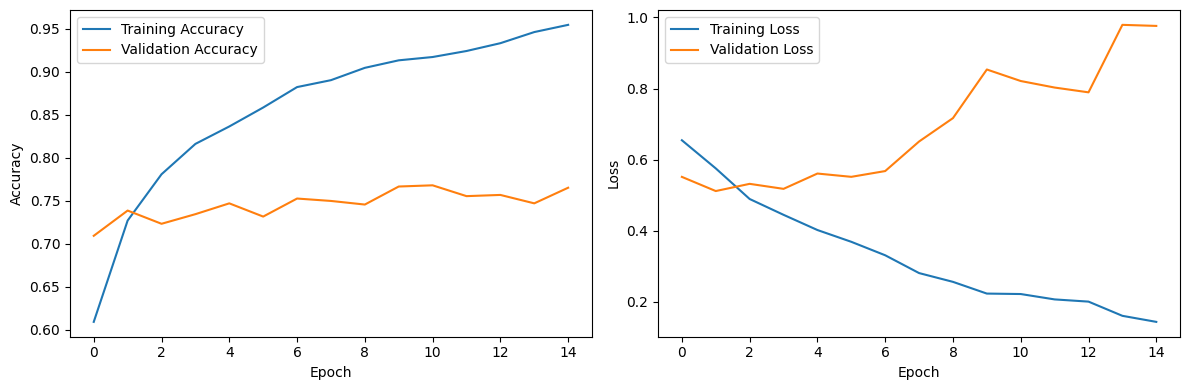

In [ ]:
# Calculate additional metrics
y_pred = model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype(int)

kappa = cohen_kappa_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy:", test_acc)
print("Kappa:", kappa)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_dnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_dnn.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dnn.history['loss'], label='Training Loss')
plt.plot(history_dnn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Define class labels if you have them
class_labels = ["O/C Left", "O/C Right"]

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Define the Bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(64, recurrent_dropout=0.2,return_sequences=True), input_shape=(x_train.shape[1], x_train.shape[2])))
# model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dropout(0.4))  # Dropout layer for regularization
model.add(Dense(10, activation=tf.nn.leaky_relu)) # Dense layer with ReLU activation
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_Bi = model.fit(x_train, y_train, epochs=10, batch_size=16, validation_data=(x_test, y_test))

Epoch 1/10
179/179 [==============================] - 171s 681ms/step - loss: 0.5352 - accuracy: 0.7125 - val_loss: 0.4956 - val_accuracy: 0.7357
Epoch 2/10
179/179 [==============================] - 83s 460ms/step - loss: 0.3823 - accuracy: 0.8199 - val_loss: 0.4925 - val_accuracy: 0.7552
Epoch 3/10
179/179 [==============================] - 82s 458ms/step - loss: 0.2953 - accuracy: 0.8776 - val_loss: 0.5474 - val_accuracy: 0.7552
Epoch 4/10
179/179 [==============================] - 85s 474ms/step - loss: 0.2354 - accuracy: 0.9056 - val_loss: 0.6264 - val_accuracy: 0.7329
Epoch 5/10
179/179 [==============================] - 83s 465ms/step - loss: 0.1573 - accuracy: 0.9402 - val_loss: 0.6704 - val_accuracy: 0.7343
Epoch 6/10
179/179 [==============================] - 81s 454ms/step - loss: 0.1425 - accuracy: 0.9447 - val_loss: 0.6627 - val_accuracy: 0.7329
Epoch 7/10
179/179 [==============================] - 83s 466ms/step - loss: 0.1311 - accuracy: 0.9482 - val_loss: 0.7737 - val_a

23/23 [==============================] - 3s 138ms/step - loss: 0.8096 - accuracy: 0.7413
Test accuracy: 0.7412587404251099
Kappa: 0.4826804018882018
F1 Score: 0.7441217150760719
Precision: 0.7289972899728997
Recall: 0.7598870056497176


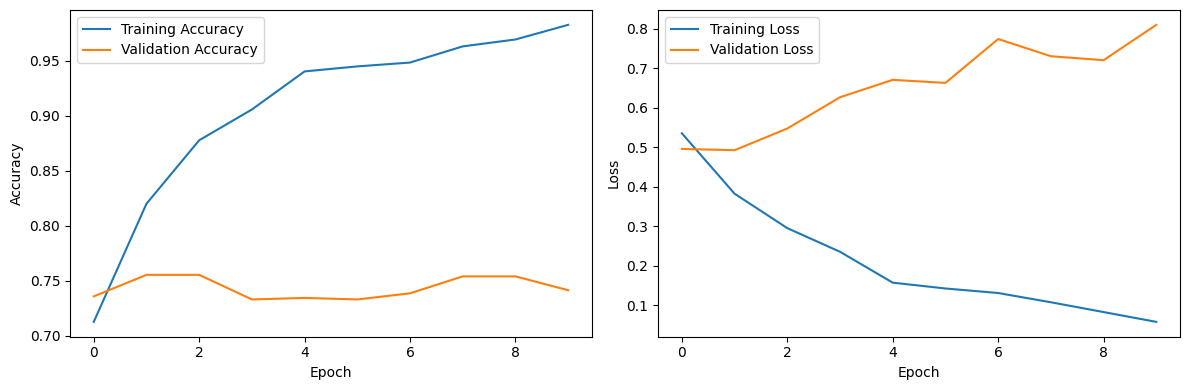

In [ ]:
# Calculate additional metrics
y_pred = model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype(int)

kappa = cohen_kappa_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy:", test_acc)
print("Kappa:", kappa)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_Bi.history['accuracy'], label='Training Accuracy')
plt.plot(history_Bi.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_Bi.history['loss'], label='Training Loss')
plt.plot(history_Bi.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

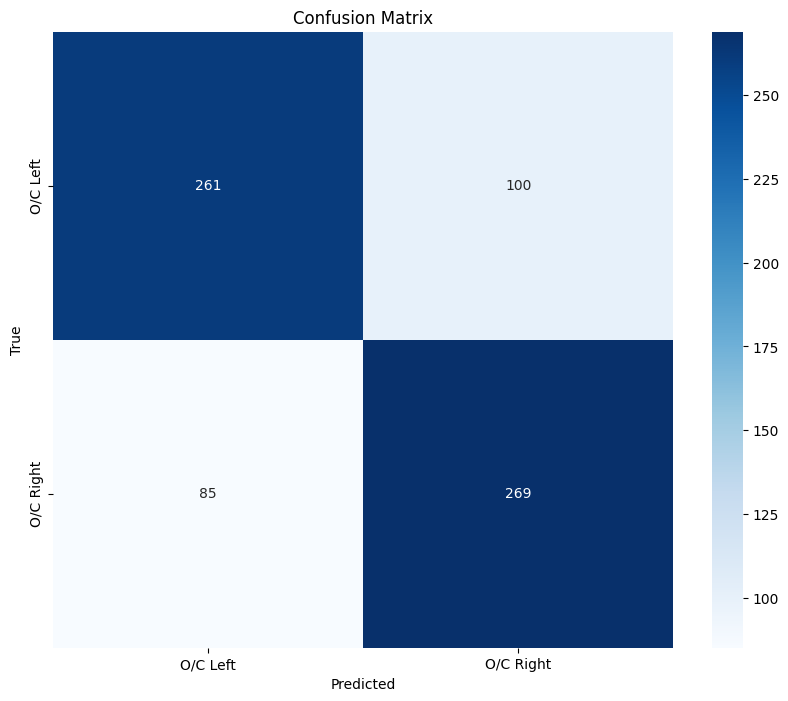

In [ ]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Define class labels if you have them
class_labels = ["O/C Left", "O/C Right"]

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
alpha = 0.01
# Define the advanced 1D CNN model
model = Sequential([
    Conv1D(64, kernel_size=3,input_shape=(x_train.shape[1], x_train.shape[2])),
    LeakyReLU(alpha=alpha),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    Conv1D(32, kernel_size=3),  # Additional Conv1D layer
    LeakyReLU(alpha=alpha),
    MaxPooling1D(pool_size=2),
    Dropout(0.65),
    Flatten(),
    Dense(64),
    LeakyReLU(alpha=alpha),
    Dropout(0.5),
    Dense(32),
    LeakyReLU(alpha=alpha),
    Dropout(0.65),
    Dense(10),
    LeakyReLU(alpha=alpha),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_cnn = model.fit(x_train, y_train, epochs=15 , batch_size=32, validation_data=(x_test, y_test))

Epoch 1/100
90/90 [==============================] - 8s 63ms/step - loss: 5.6674 - accuracy: 0.4914 - val_loss: 0.6908 - val_accuracy: 0.5091
Epoch 2/100
90/90 [==============================] - 3s 36ms/step - loss: 1.6635 - accuracy: 0.4984 - val_loss: 0.6930 - val_accuracy: 0.5133
Epoch 3/100
90/90 [==============================] - 4s 48ms/step - loss: 1.0671 - accuracy: 0.5009 - val_loss: 0.6951 - val_accuracy: 0.5049
Epoch 4/100
90/90 [==============================] - 3s 37ms/step - loss: 0.9584 - accuracy: 0.5037 - val_loss: 0.6961 - val_accuracy: 0.5063
Epoch 5/100
90/90 [==============================] - 4s 43ms/step - loss: 0.8229 - accuracy: 0.5075 - val_loss: 0.6961 - val_accuracy: 0.5063
Epoch 6/100
90/90 [==============================] - 4s 49ms/step - loss: 0.8010 - accuracy: 0.5180 - val_loss: 0.6966 - val_accuracy: 0.5049
Epoch 7/100
90/90 [==============================] - 3s 33ms/step - loss: 0.7631 - accuracy: 0.5145 - val_loss: 0.6964 - val_accuracy: 0.5049
Epoch 

KeyboardInterrupt: ignored

In [ ]:
# Calculate additional metrics
y_pred = model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype(int)

kappa = cohen_kappa_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy:", test_acc)
print("Kappa:", kappa)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Define class labels if you have them
class_labels = ["O/C Left", "O/C Right"]

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()